In [1]:
from google.colab import files
import os
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt

Summrize all metadata files

In [2]:
def summarize_metadata(metadata_path):
    rows = []
    for file in os.listdir(metadata_path):
        if file.endswith(".json"):
            with open(os.path.join(metadata_path, file), "r") as f:
                data = json.load(f)
            starts = [datetime.fromisoformat(t.replace("Z", "")) for t in data["calibration_started"]]
            ends = [datetime.fromisoformat(t.replace("Z", "")) for t in data["back_from_calibration"]]
            durations = [(e - s).total_seconds() for s, e in zip(starts, ends)]
            total_time = sum(durations)
            mean_time = total_time / len(durations) if durations else 0
            rows.append({
                "user_id": data["user_id"],
                "video_id": data["video_id"],
                "count_calibrations": len(durations),
                "total_calibration_time": total_time,
                "mean_calibration_time": mean_time
            })
    return pd.DataFrame(rows)

Upload metadata JSON files

In [3]:
print("Please upload ALL metadata JSON files (one or more):")
uploaded_metadata = files.upload()

metadata_dir = "uploaded_metadata"
os.makedirs(metadata_dir, exist_ok=True)
for filename, content in uploaded_metadata.items():
    with open(os.path.join(metadata_dir, filename), "wb") as f:
        f.write(content)

metadata_summary = summarize_metadata(metadata_dir)

Please upload ALL metadata JSON files (one or more):


Saving metadata11.json to metadata11.json
Saving metadata12.json to metadata12.json
Saving metadata13.json to metadata13.json
Saving metadata21.json to metadata21.json
Saving metadata22.json to metadata22.json
Saving metadata23.json to metadata23.json
Saving metadata31.json to metadata31.json
Saving metadata32.json to metadata32.json
Saving metadata33.json to metadata33.json
Saving metadata41.json to metadata41.json
Saving metadata42.json to metadata42.json
Saving metadata43.json to metadata43.json
Saving metadata51.json to metadata51.json
Saving metadata52.json to metadata52.json
Saving metadata53.json to metadata53.json


Upload performance CSV file

In [4]:
print("\nPlease upload the performance CSV file:")
uploaded_performance = files.upload()

performance_filename = list(uploaded_performance.keys())[0]
performance_path = os.path.join(".", performance_filename)
with open(performance_path, "wb") as f:
    f.write(uploaded_performance[performance_filename])

performance = pd.read_csv(performance_path)


Please upload the performance CSV file:


Saving mean_biofeedback_results_mays_with_t.csv to mean_biofeedback_results_mays_with_t.csv


Reshape performance data

In [5]:
melted = performance.melt(
    id_vars=["participant"],
    value_vars=["Merav1_mean", "Merav2_mean", "Merav3_mean"],
    var_name="video_id",
    value_name="performance_score"
)
melted["video_id"] = melted["video_id"].str.replace("_mean", "")
melted.rename(columns={"participant": "user_id"}, inplace=True)


Merge performance + metadata

In [6]:
merged = melted.merge(metadata_summary, on=["user_id", "video_id"], how="left")


Correlation analysis

In [7]:
corrs = merged[["performance_score", "count_calibrations", "total_calibration_time", "mean_calibration_time"]].corr(method="pearson")
print("\nCorrelation matrix:\n", corrs)



Correlation matrix:
                         performance_score  count_calibrations  \
performance_score                1.000000           -0.403298   
count_calibrations              -0.403298            1.000000   
total_calibration_time           0.090867           -0.796003   
mean_calibration_time            0.112493           -0.700903   

                        total_calibration_time  mean_calibration_time  
performance_score                     0.090867               0.112493  
count_calibrations                   -0.796003              -0.700903  
total_calibration_time                1.000000               0.967374  
mean_calibration_time                 0.967374               1.000000  


 Save and visualize


✅ Saved merged results as 'correlation_results.csv'. You can download it below:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Correlation matrix:
                         performance_score  count_calibrations  \
performance_score                1.000000           -0.403298   
count_calibrations              -0.403298            1.000000   
total_calibration_time           0.090867           -0.796003   
mean_calibration_time            0.112493           -0.700903   

                        total_calibration_time  mean_calibration_time  
performance_score                     0.090867               0.112493  
count_calibrations                   -0.796003              -0.700903  
total_calibration_time                1.000000               0.967374  
mean_calibration_time                 0.967374               1.000000  


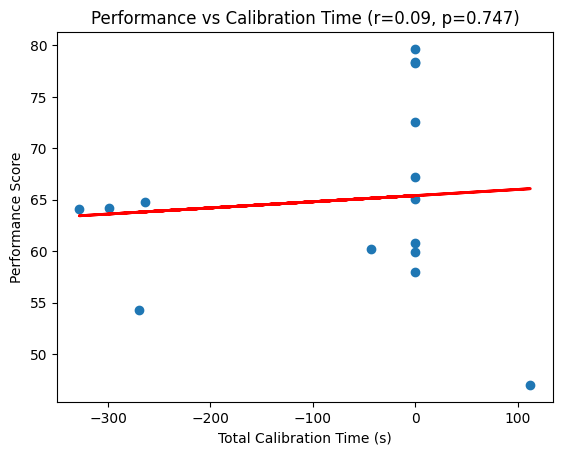

In [9]:
import statsmodels.api as sm
from scipy import stats

merged.to_csv("correlation_results.csv", index=False)
print("\nSaved merged results as 'correlation_results.csv'. You can download it below:")

files.download("correlation_results.csv")

# Correlation analysis
corrs = merged[["performance_score", "count_calibrations", "total_calibration_time", "mean_calibration_time"]].corr(method="pearson")
print("\nCorrelation matrix:\n", corrs)

# Regression analysis and plot for Performance vs Total Calibration Time
X = merged["total_calibration_time"]
Y = merged["performance_score"]
X = sm.add_constant(X) # Add a constant term to the independent variable
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

# Get correlation and p-value
corr_value = corrs.loc["total_calibration_time", "performance_score"]
p_value = model.pvalues["total_calibration_time"]

plt.scatter(merged["total_calibration_time"], merged["performance_score"])
plt.plot(merged["total_calibration_time"], predictions, color='red', linestyle='-', linewidth=2)
plt.xlabel("Total Calibration Time (s)")
plt.ylabel("Performance Score")
plt.title(f"Performance vs Calibration Time (r={corr_value:.2f}, p={p_value:.3f})")
plt.show()


📈 Correlation with number of calibrations only:
                    performance_score  count_calibrations
performance_score            1.000000           -0.403298
count_calibrations          -0.403298            1.000000


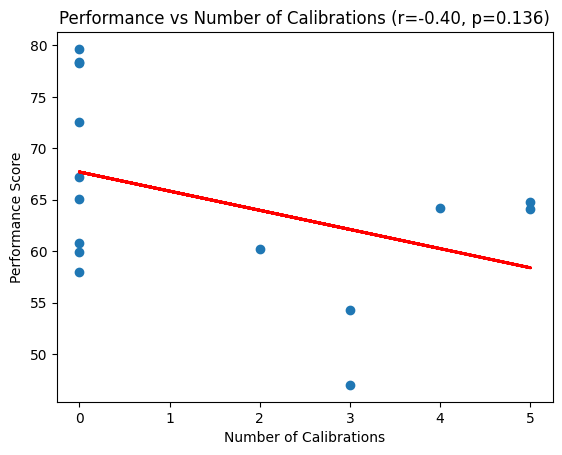

In [10]:
import statsmodels.api as sm
from scipy import stats

print("\nCorrelation with number of calibrations only:")

# Pearson correlation between performance and count of calibrations
corr_count = merged[["performance_score", "count_calibrations"]].corr(method="pearson")
print(corr_count)

# Regression analysis for Performance vs Number of Calibrations
X_count = merged["count_calibrations"]
Y_count = merged["performance_score"]
X_count = sm.add_constant(X_count) # Add a constant term to the independent variable
model_count = sm.OLS(Y_count, X_count).fit()
predictions_count = model_count.predict(X_count)

# Get correlation and p-value
corr_value_count = corr_count.loc["performance_score", "count_calibrations"]
p_value_count = model_count.pvalues["count_calibrations"]


# Optional: visualize relationship
plt.scatter(merged["count_calibrations"], merged["performance_score"])
plt.plot(merged["count_calibrations"], predictions_count, color='red', linestyle='-', linewidth=2)
plt.xlabel("Number of Calibrations")
plt.ylabel("Performance Score")
plt.title(f"Performance vs Number of Calibrations (r={corr_value_count:.2f}, p={p_value_count:.3f})")
plt.show()

Survey data summary


In [11]:
# === Step 1: Upload all survey JSON files ===
print("Please upload ALL survey_*.json files:")
uploaded_files = files.upload()

# === Step 2: Save uploaded files temporarily ===
survey_dir = "uploaded_surveys"
os.makedirs(survey_dir, exist_ok=True)

for filename, content in uploaded_files.items():
    with open(os.path.join(survey_dir, filename), "wb") as f:
        f.write(content)

# === Step 3: Parse all JSONs and build a summary ===
rows = []
for file in os.listdir(survey_dir):
    if file.endswith(".json"):
        with open(os.path.join(survey_dir, file), "r") as f:
            data = json.load(f)
        rows.append({
            "user_id": data.get("user_id"),
            "video_id": data.get("video_id"),
            "EnjoymentRating": data.get("EnjoymentRating"),
            "FutureActivityRating": data.get("FutureActivityRating")
        })

# === Step 4: Create and sort DataFrame ===
df = pd.DataFrame(rows)
df.sort_values(by=["user_id", "video_id"], inplace=True)
print("\nCombined survey table:\n")
print(df)

# === Step 5: Save as CSV and download ===
output_file = "survey_summary.csv"
df.to_csv(output_file, index=False)
print(f"\nSaved summary as {output_file}")
files.download(output_file)

Please upload ALL survey_*.json files:


Saving survey_Merav1_5d8emj4fNdetBIiA6bowYPoiA3p1_1759930264769.json to survey_Merav1_5d8emj4fNdetBIiA6bowYPoiA3p1_1759930264769.json
Saving survey_Merav1_lBr4A7KMSxeGrInkKSVywKVuhSr2_1759932003011.json to survey_Merav1_lBr4A7KMSxeGrInkKSVywKVuhSr2_1759932003011.json
Saving survey_Merav1_Pfy49P049RO1ebsaoGkYBMt0LKz2_1754670363591.json to survey_Merav1_Pfy49P049RO1ebsaoGkYBMt0LKz2_1754670363591.json
Saving survey_Merav1_RYQgLopjQVfHkm6XvSsIANjcmH43_1754674009141.json to survey_Merav1_RYQgLopjQVfHkm6XvSsIANjcmH43_1754674009141.json
Saving survey_Merav1_umcIypojgiNd92tjJGjpWEffb5R2_1760125882836.json to survey_Merav1_umcIypojgiNd92tjJGjpWEffb5R2_1760125882836.json
Saving survey_Merav2_5d8emj4fNdetBIiA6bowYPoiA3p1_1760206399256.json to survey_Merav2_5d8emj4fNdetBIiA6bowYPoiA3p1_1760206399256.json
Saving survey_Merav2_lBr4A7KMSxeGrInkKSVywKVuhSr2_1760029333482.json to survey_Merav2_lBr4A7KMSxeGrInkKSVywKVuhSr2_1760029333482.json
Saving survey_Merav2_Pfy49P049RO1ebsaoGkYBMt0LKz2_175476489718

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Survey and performance correlation analysis


Correlation matrix between performance and survey ratings:
                       performance_score  EnjoymentRating  FutureActivityRating
performance_score               1.00000         -0.20226              -0.00632
EnjoymentRating                -0.20226          1.00000               0.82726
FutureActivityRating           -0.00632          0.82726               1.00000


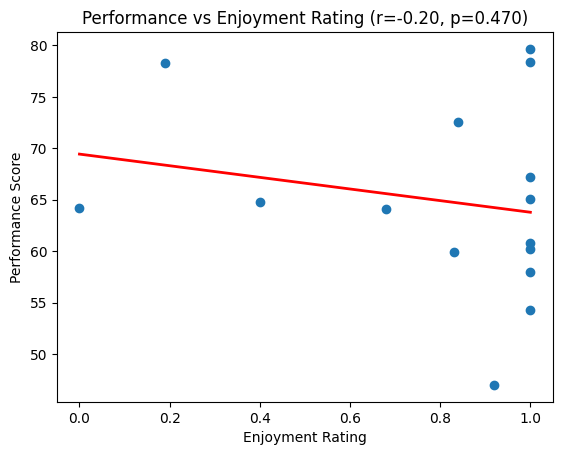

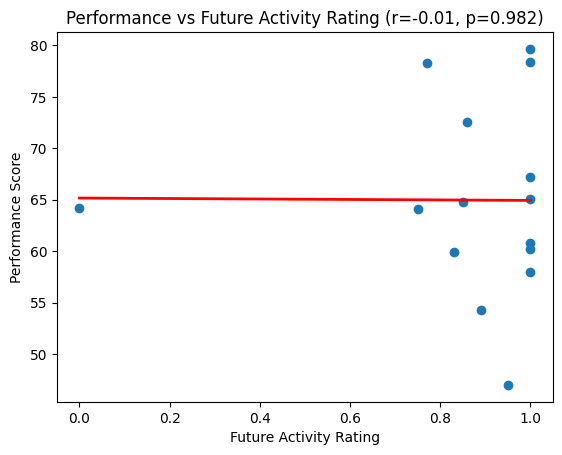

In [13]:
import statsmodels.api as sm
from scipy import stats
import numpy as np

# Merge the survey data with the existing merged DataFrame
merged_with_survey = merged.merge(df, on=["user_id", "video_id"], how="left")

# Calculate correlations including survey ratings
corrs_with_survey = merged_with_survey[["performance_score", "EnjoymentRating", "FutureActivityRating"]].corr(method="pearson")

print("\nCorrelation matrix between performance and survey ratings:\n", corrs_with_survey)

# Get the correlation values
corr_enjoyment = corrs_with_survey.loc["performance_score", "EnjoymentRating"]
corr_future_activity = corrs_with_survey.loc["performance_score", "FutureActivityRating"]

# Regression analysis for Performance vs Enjoyment Rating
# Drop NaNs for regression and align performance with enjoyment
regression_data_enjoyment = merged_with_survey[["EnjoymentRating", "performance_score"]].dropna()
X_enjoyment = regression_data_enjoyment["EnjoymentRating"]
Y_enjoyment = regression_data_enjoyment["performance_score"]
X_enjoyment = sm.add_constant(X_enjoyment) # Add a constant term
model_enjoyment = sm.OLS(Y_enjoyment, X_enjoyment).fit()
predictions_enjoyment = model_enjoyment.predict(X_enjoyment)

# Sort data for plotting the regression line
sort_index_enjoyment = regression_data_enjoyment["EnjoymentRating"].argsort()
X_enjoyment_sorted = X_enjoyment.iloc[sort_index_enjoyment]
predictions_enjoyment_sorted = predictions_enjoyment.iloc[sort_index_enjoyment]


# Get p-value for Enjoyment Rating
p_value_enjoyment = model_enjoyment.pvalues["EnjoymentRating"]


# Plot Performance vs Enjoyment Rating with regression line and p-value
plt.scatter(merged_with_survey["EnjoymentRating"], merged_with_survey["performance_score"])
plt.plot(X_enjoyment_sorted["EnjoymentRating"], predictions_enjoyment_sorted, color='red', linestyle='-', linewidth=2)
plt.xlabel("Enjoyment Rating")
plt.ylabel("Performance Score")
plt.title(f"Performance vs Enjoyment Rating (r={corr_enjoyment:.2f}, p={p_value_enjoyment:.3f})")
plt.show()

# Regression analysis for Performance vs Future Activity Rating
# Drop NaNs for regression and align performance with future activity
regression_data_future_activity = merged_with_survey[["FutureActivityRating", "performance_score"]].dropna()
X_future_activity = regression_data_future_activity["FutureActivityRating"]
Y_future_activity = regression_data_future_activity["performance_score"]
X_future_activity = sm.add_constant(X_future_activity) # Add a constant term
model_future_activity = sm.OLS(Y_future_activity, X_future_activity).fit()
predictions_future_activity = model_future_activity.predict(X_future_activity)

# Sort data for plotting the regression line
sort_index_future_activity = regression_data_future_activity["FutureActivityRating"].argsort()
X_future_activity_sorted = X_future_activity.iloc[sort_index_future_activity]
predictions_future_activity_sorted = predictions_future_activity.iloc[sort_index_future_activity]

# Get p-value for Future Activity Rating
p_value_future_activity = model_future_activity.pvalues["FutureActivityRating"]

# Plot Performance vs Future Activity Rating with regression line and p-value
plt.scatter(merged_with_survey["FutureActivityRating"], merged_with_survey["performance_score"])
plt.plot(X_future_activity_sorted["FutureActivityRating"], predictions_future_activity_sorted, color='red', linestyle='-', linewidth=2)
plt.xlabel("Future Activity Rating")
plt.ylabel("Performance Score")
plt.title(f"Performance vs Future Activity Rating (r={corr_future_activity:.2f}, p={p_value_future_activity:.3f})")
plt.show()